# Projeto Final - Segurança da Informação
Gabriel Beloso e Rafaela Vilela

Notebook contém: dataset de pares, extração de características, 10-fold, métricas e gráficos.

**Saídas geradas em disco:**
- `results/metricas_finais.csv`
- `results/CM_<FEATURE>_<MODELO>.csv`
- `results/ROC_<FEATURE>_<MODELO>.png`
- `results/plots/*.png`


In [1]:

# Importação e configurações
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub

from skimage.transform import resize
from skimage.feature import hog, local_binary_pattern

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc
)

#mantar o drive
#from google.colab import drive
#drive.mount('/content/drive')

print("✅ Imports carregados.")


C:\Users\gbelo\Documents\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Imports carregados.


## Leitura dos pares (dataset LFW)

In [2]:
path = kagglehub.dataset_download("jessicali9530/lfw-dataset")

In [3]:

#Carregamento dos pares
def read_pairs_lfw_images(path_file, base_dir):
    """
    Lê o arquivo 'pairs.csv', carrega as imagens em Grayscale e retorna os pares.
    Retorna: list of tuples (imagem_array1, imagem_array2, label)
    label=1: mesma pessoa | label=0: pessoas diferentes
    """
    pairs = []

    if not os.path.exists(path_file):
        raise FileNotFoundError(f"Arquivo de pares não encontrado: {path_file}")

    with open(path_file, 'r') as f:
        lines = f.readlines()[1:]  # Pula o cabeçalho

    print(f"Processando {len(lines)} linhas do arquivo de pares...")

    for line in lines:
        parts = line.strip().split(',')

        # Correção para vírgulas extras no final
        if parts and parts[-1] == '':
            parts = parts[:-1]

        img1_path_rel = ""
        img2_path_rel = ""
        label = 0

        if len(parts) == 3:
            # Caso positivo: Name, ID1, ID2
            name = parts[0]
            id1 = int(parts[1])
            id2 = int(parts[2])

            img1_path_rel = f"{name}/{name}_{id1:04d}.jpg"
            img2_path_rel = f"{name}/{name}_{id2:04d}.jpg"
            label = 1

        elif len(parts) == 4:
            # Caso negativo: name1, ID1, name2, ID2
            name1 = parts[0]
            id1 = int(parts[1])
            name2 = parts[2]
            id2 = int(parts[3])

            img1_path_rel = f"{name1}/{name1}_{id1:04d}.jpg"
            img2_path_rel = f"{name2}/{name2}_{id2:04d}.jpg"
            label = 0
        else:
            continue  # Linha inválida

        full_path1 = os.path.join(base_dir, fr'lfw-deepfunneled\lfw-deepfunneled', img1_path_rel)
        full_path2 = os.path.join(base_dir, fr'lfw-deepfunneled\lfw-deepfunneled', img2_path_rel)
        
        img1_data = cv2.imread(full_path1, cv2.IMREAD_GRAYSCALE)
        img2_data = cv2.imread(full_path2, cv2.IMREAD_GRAYSCALE)

        if img1_data is None or img2_data is None:
            print(f"Aviso: Falha ao carregar: {img1_path_rel} ou {img2_path_rel}")
            continue

        pairs.append((img1_data, img2_data, label))

    print(f"✅ Total de pares válidos: {len(pairs)}")
    return pairs

BASE_DIR = path
PAIRS_CSV = os.path.join(BASE_DIR, "pairs.csv")

pairs = read_pairs_lfw_images(PAIRS_CSV, BASE_DIR)

images_1 = [p[0] for p in pairs]
images_2 = [p[1] for p in pairs]
labels   = [p[2] for p in pairs]

print("✅ Pares preparados:", len(labels))


Processando 6000 linhas do arquivo de pares...
✅ Total de pares válidos: 6000
✅ Pares preparados: 6000


## Extratores de características 
HOG (resize 64×64), LBPH (histograma LBP uniform), Hu Moments (forma via limiarização Otsu).

In [4]:

# definiçãao dos extratores
def get_hog_from_images(image):
    a = resize(image, (64, 64), anti_aliasing=True)
    return hog(
        a, orientations=9, pixels_per_cell=(8, 8),
        cells_per_block=(2, 2), block_norm='L2-Hys',
        feature_vector=True
    )

def get_lbp_from_images(image):
    METHOD = 'uniform'
    P_neighbors = 8
    R_radius = 1
    n_bins = P_neighbors + 2
    lbp = local_binary_pattern(image, P_neighbors, R_radius, METHOD)
    return np.histogram(lbp.ravel(), bins=range(0, n_bins + 1), density=True)[0]

def get_hu_moments(image):
    # Binarização OTSU para capturar a silhueta
    _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    moments = cv2.moments(thresh)
    hu = cv2.HuMoments(moments)

    # Log transform para estabilizar escala
    for i in range(7):
        val = hu[i]
        if val != 0:
            hu[i] = -1 * np.copysign(1.0, val) * np.log10(abs(val))
        else:
            hu[i] = 0

    return hu.flatten()


## Métricas + ROC + EER
A avaliação junta os 10 folds (concatenando as predições) para gerar métricas finais por (Feature, Modelo).

In [5]:

def compute_eer(fpr, tpr):
    fnr = 1 - tpr
    idx = np.nanargmin(np.abs(fpr - fnr))
    eer = (fpr[idx] + fnr[idx]) / 2
    return eer, idx

def evaluate_and_save(y_true, y_pred, y_score, feature_name, model_name, output_dir="results"):
    os.makedirs(output_dir, exist_ok=True)

    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    eer, eer_idx = compute_eer(fpr, tpr)

    #salvar ROC
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1],[0,1],'--')
    plt.scatter(fpr[eer_idx], tpr[eer_idx], label=f"EER = {eer:.4f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC - {feature_name} - {model_name}")
    plt.legend()
    plt.grid(True)

    roc_path = f"{output_dir}/ROC_{feature_name}_{model_name}.png"
    plt.savefig(roc_path, dpi=300, bbox_inches="tight")
    plt.close()

    #salvar Matriz de Confusão (CSV)
    cm_df = pd.DataFrame(cm, index=["Real 0", "Real 1"], columns=["Pred 0", "Pred 1"])
    cm_csv = f"{output_dir}/CM_{feature_name}_{model_name}.csv"
    cm_df.to_csv(cm_csv)

    return {
        "Feature": feature_name,
        "Modelo": model_name,
        "Acuracia": acc,
        "Precisao": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": roc_auc,
        "EER": eer
    }


## Execução 10-fold (SVM / KNN / RF)
Define `fold_size` de acordo com o dataset (600 por fold para 10 folds = 6000 amostras).

In [6]:

def run_experiment_and_save(features_1, features_2, labels, feature_name, fold_size=600, output_dir="results"):
    X_all = np.abs(features_1 - features_2)
    y_all = np.array(labels).astype(int)

    models = {
        "SVM": SVC(kernel="linear", probability=True, random_state=42),
        "KNN": KNeighborsClassifier(n_neighbors=5, metric="minkowski", p=1),
        "RF": RandomForestClassifier(n_estimators=100, random_state=42)
    }

    store = {m: {"y_true": [], "y_pred": [], "y_score": []} for m in models}

    for i in range(10):
        tb, te = i * fold_size, (i + 1) * fold_size

        X_test, y_test = X_all[tb:te], y_all[tb:te]
        X_train = np.vstack((X_all[:tb], X_all[te:]))
        y_train = np.hstack((y_all[:tb], y_all[te:]))

        for name, clf in models.items():
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            y_score = clf.predict_proba(X_test)[:, 1]  # score contínuo para ROC/EER

            store[name]["y_true"].append(y_test)
            store[name]["y_pred"].append(y_pred)
            store[name]["y_score"].append(y_score)

    metrics_all = []
    for name in models:
        y_true = np.concatenate(store[name]["y_true"])
        y_pred = np.concatenate(store[name]["y_pred"])
        y_score = np.concatenate(store[name]["y_score"])

        metrics = evaluate_and_save(y_true, y_pred, y_score, feature_name, name, output_dir=output_dir)
        metrics_all.append(metrics)

    return pd.DataFrame(metrics_all)

print("✅ Função 10-fold pronta.")


✅ Função 10-fold pronta.


## Execução HOG / LBPH / HUM
Resultados armazenados em `results/metricas_finais.csv`.

In [7]:

os.makedirs("results", exist_ok=True)

# HOG
f1_hog = np.array([get_hog_from_images(img) for img in images_1])
f2_hog = np.array([get_hog_from_images(img) for img in images_2])
df_hog = run_experiment_and_save(f1_hog, f2_hog, labels, "HOG", fold_size=600, output_dir="results")

# LBPH
f1_lbp = np.array([get_lbp_from_images(img) for img in images_1])
f2_lbp = np.array([get_lbp_from_images(img) for img in images_2])
df_lbp = run_experiment_and_save(f1_lbp, f2_lbp, labels, "LBPH", fold_size=600, output_dir="results")

# HUM (Hu Moments)
f1_hu = np.array([get_hu_moments(img) for img in images_1])
f2_hu = np.array([get_hu_moments(img) for img in images_2])
df_hu = run_experiment_and_save(f1_hu, f2_hu, labels, "HUM", fold_size=600, output_dir="results")

df_final = pd.concat([df_lbp, df_hog, df_hu], axis=0).reset_index(drop=True)
df_final.to_csv("results/metricas_finais.csv", index=False)

display(df_final)
print("✅ Salvo: results/metricas_finais.csv")


,Feature,Modelo,Acuracia,Precisao,Recall,F1,AUC,EER
0,LBPH,SVM,0.528500,0.518738,0.789000,0.625942,0.554342,0.463000
1,LBPH,KNN,0.515833,0.514904,0.547000,0.530467,0.524241,0.484167
2,LBPH,RF,0.534667,0.535495,0.523000,0.529174,0.543857,0.465333
3,HOG,SVM,0.650333,0.648649,0.656000,0.652304,0.709133,0.349500
4,HOG,KNN,0.520667,0.510847,0.973333,0.670032,0.611220,0.398833
5,HOG,RF,0.671167,0.687477,0.627667,0.656212,0.726747,0.333667
6,HUM,SVM,0.546000,0.531109,0.785333,0.633674,0.573474,0.447667
7,HUM,KNN,0.502500,0.502447,0.513333,0.507832,0.503586,0.497500
8,HUM,RF,0.535500,0.535512,0.535333,0.535423,0.545026,0.464500


✅ Salvo: results/metricas_finais.csv


## Apresentação de Resultados e gráficos

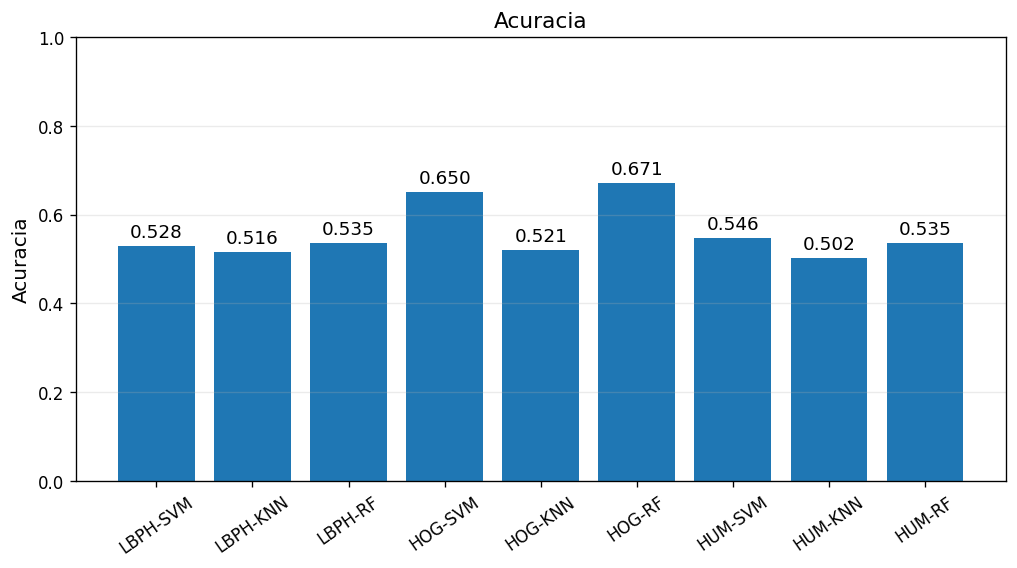

✅ Salvo em: results/plots\bar_all_Acuracia.png


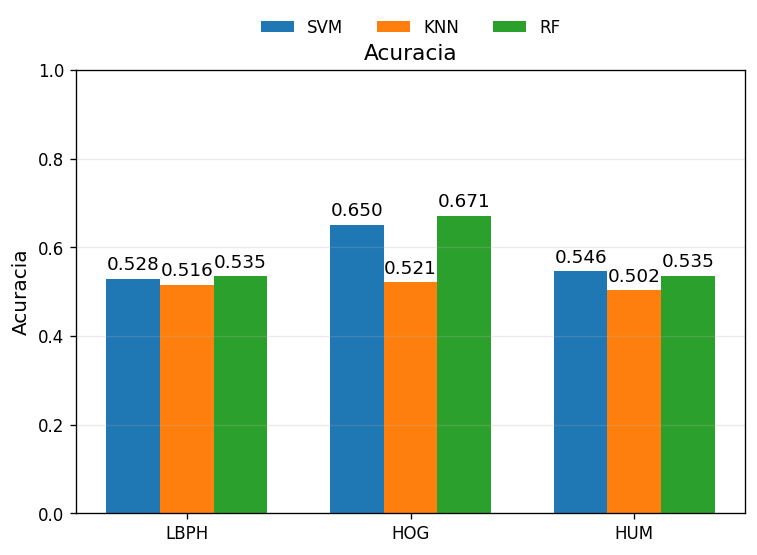

✅ Salvo em: results/plots\bar_grouped_feature_Acuracia.png


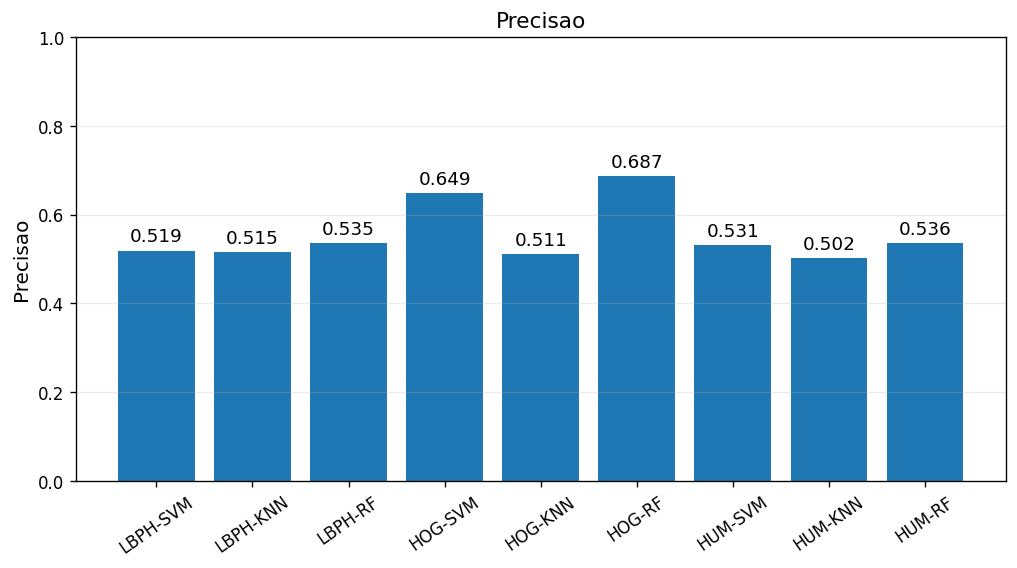

✅ Salvo em: results/plots\bar_all_Precisao.png


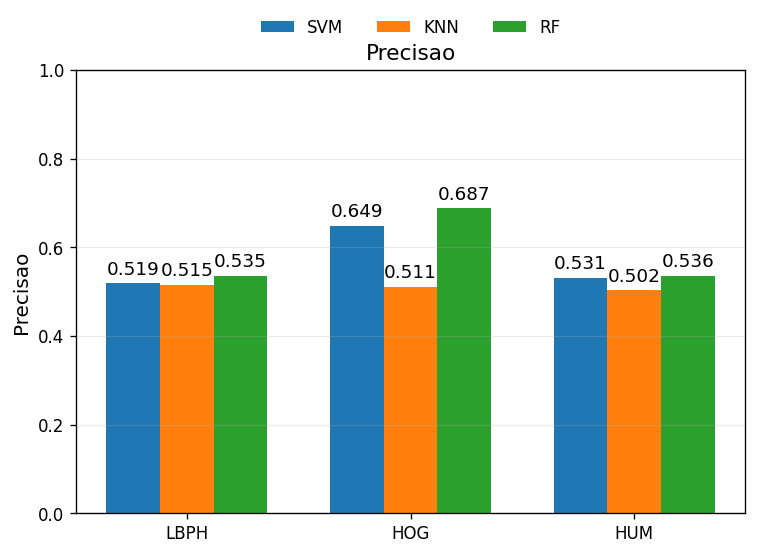

✅ Salvo em: results/plots\bar_grouped_feature_Precisao.png


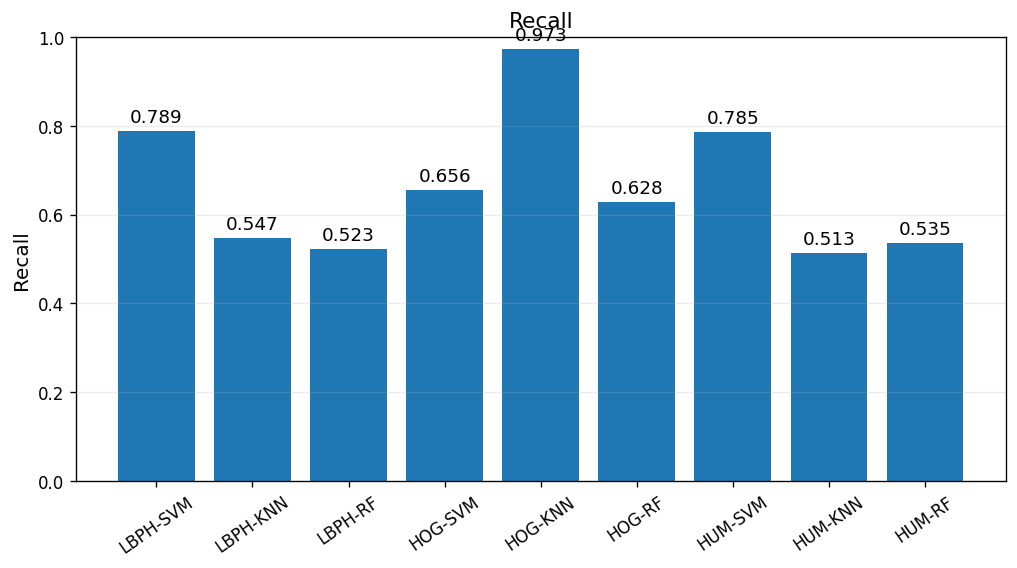

✅ Salvo em: results/plots\bar_all_Recall.png


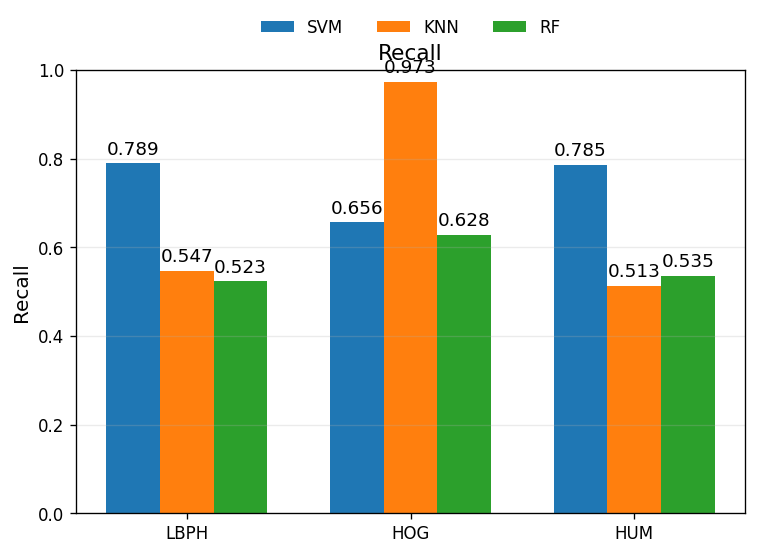

✅ Salvo em: results/plots\bar_grouped_feature_Recall.png


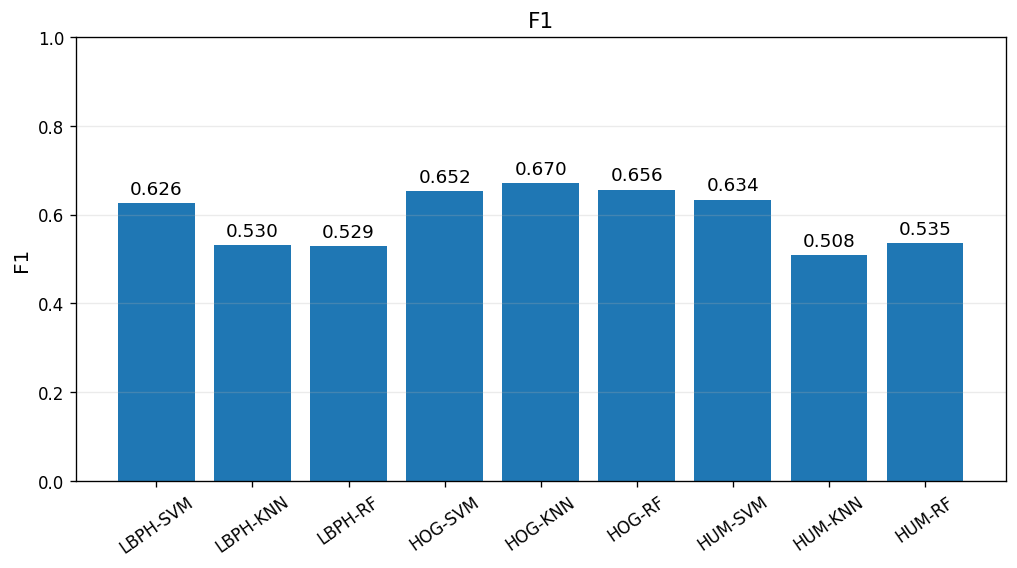

✅ Salvo em: results/plots\bar_all_F1.png


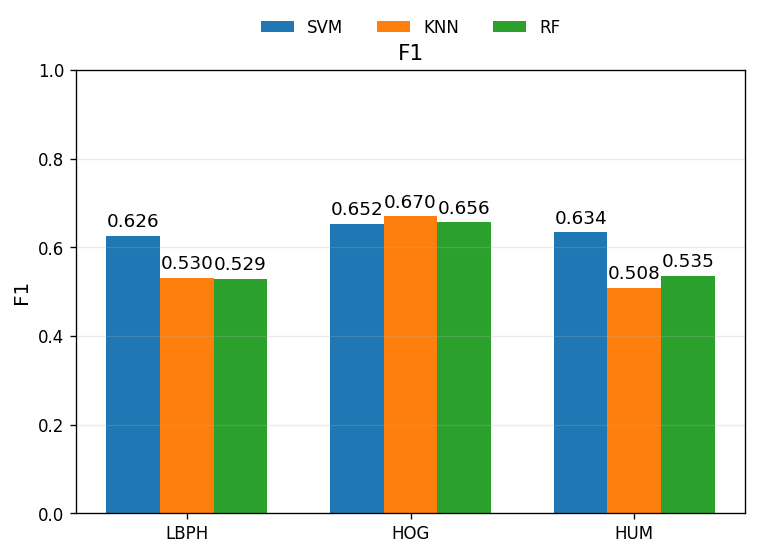

✅ Salvo em: results/plots\bar_grouped_feature_F1.png


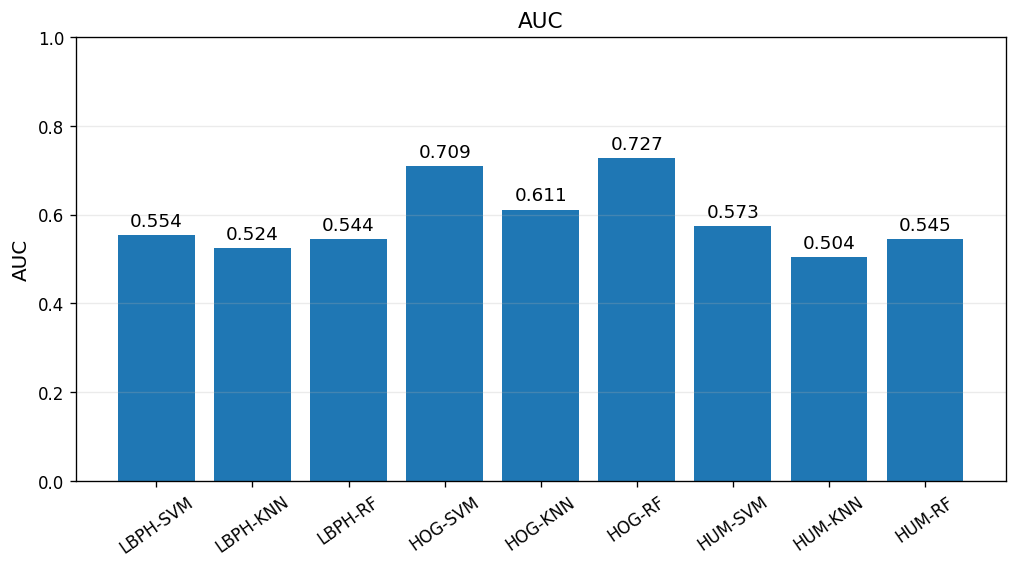

✅ Salvo em: results/plots\bar_all_AUC.png


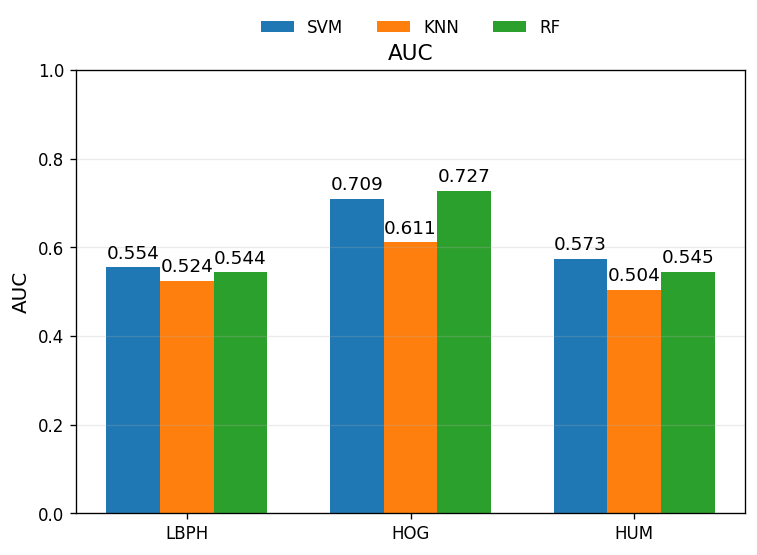

✅ Salvo em: results/plots\bar_grouped_feature_AUC.png


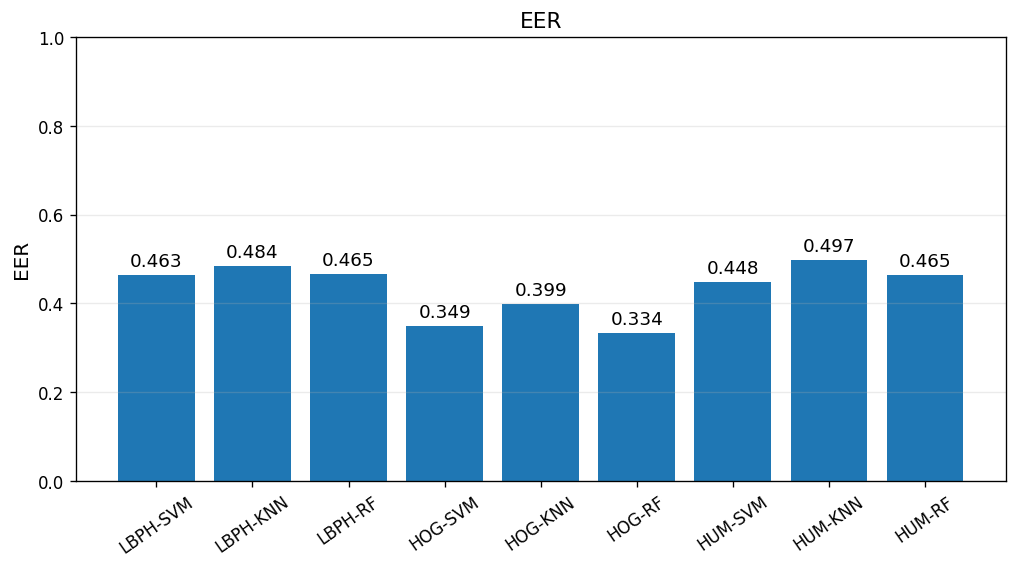

✅ Salvo em: results/plots\bar_all_EER.png


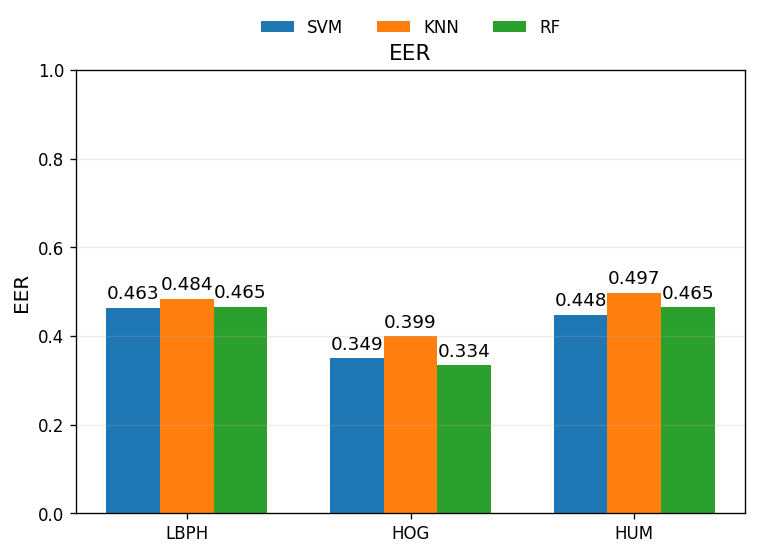

✅ Salvo em: results/plots\bar_grouped_feature_EER.png
✅ Gráficos gerados em results/plots/


In [8]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("results/metricas_finais.csv")

feature_order = ["LBPH", "HOG", "HUM"]
model_order = ["SVM", "KNN", "RF"]

df["Feature"] = pd.Categorical(df["Feature"], categories=feature_order, ordered=True)
df["Modelo"]  = pd.Categorical(df["Modelo"],  categories=model_order,  ordered=True)
df = df.sort_values(["Feature", "Modelo"]).reset_index(drop=True)

plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.dpi": 120
})

OUT_DIR = "results/plots"
os.makedirs(OUT_DIR, exist_ok=True)

def _add_value_labels(ax, fmt="{:.3f}"):
    for p in ax.patches:
        h = p.get_height()
        ax.annotate(fmt.format(h),
                    (p.get_x() + p.get_width()/2, h),
                    ha="center", va="bottom",
                    xytext=(0, 3), textcoords="offset points")

def save_and_show(fig, filename):
    path = os.path.join(OUT_DIR, filename)
    fig.savefig(path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"✅ Salvo em: {path}")

def plot_metric_all_bars(df, metric, ylim=(0, 1)):
    labels = [f"{r.Feature}-{r.Modelo}" for _, r in df.iterrows()]
    values = df[metric].astype(float).values

    fig, ax = plt.subplots(figsize=(10, 4.8))
    ax.bar(labels, values)
    ax.set_title(metric)
    ax.set_ylabel(metric)
    ax.set_ylim(*ylim)
    ax.grid(axis="y", alpha=0.25)
    ax.tick_params(axis="x", rotation=35)
    _add_value_labels(ax)
    save_and_show(fig, f"bar_all_{metric}.png")

def plot_metric_grouped_by_feature(df, metric, ylim=(0, 1)):
    pivot = df.pivot(index="Feature", columns="Modelo", values=metric).reindex(feature_order)[model_order]

    x = np.arange(len(pivot.index))
    width = 0.24

    fig, ax = plt.subplots(figsize=(7.2, 4.8))
    for i, model in enumerate(model_order):
        ax.bar(x + (i-1)*width, pivot[model].values.astype(float), width, label=model)

    ax.set_title(metric)
    ax.set_ylabel(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(pivot.index.tolist())
    ax.set_ylim(*ylim)
    ax.grid(axis="y", alpha=0.25)
    ax.legend(frameon=False, ncol=3, loc="upper center", bbox_to_anchor=(0.5, 1.15))
    _add_value_labels(ax)
    save_and_show(fig, f"bar_grouped_feature_{metric}.png")

metrics = ["Acuracia", "Precisao", "Recall", "F1", "AUC", "EER"]

for m in metrics:
    plot_metric_all_bars(df, m, ylim=(0, 1))
    plot_metric_grouped_by_feature(df, m, ylim=(0, 1))

print("✅ Gráficos gerados em results/plots/")


# Curva ROC

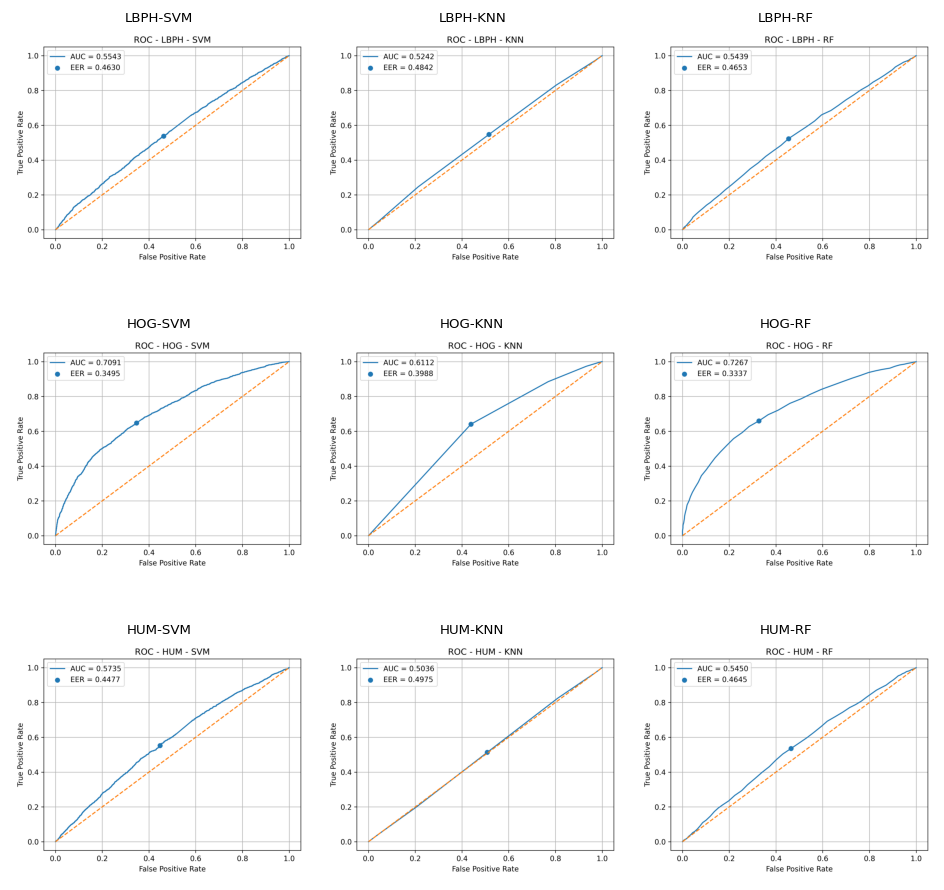

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axes = plt.subplots(3, 3, figsize=(8, 8))

for i, feat in enumerate(["LBPH", "HOG", "HUM"]):
    for j, model in enumerate(["SVM", "KNN", "RF"]):
        path = f"results/ROC_{feat}_{model}.png"
        img = mpimg.imread(path)
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        axes[i, j].set_title(f"{feat}-{model}", fontsize=8)

plt.tight_layout()
plt.show()

